# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

O Loggi Benchmark for Urban Deliveries (BUD) é um repositório do GitHub ([link](https://github.com/loggi/loggibud)) com dados e códigos para problemas típicos que empresas de logística enfrentam: otimização das rotas de entrega, alocação de entregas nos veículos da frota com capacidade limitada, etc. Os dados são sintetizados de fontes públicas (IBGE, IPEA, etc.) e são representativos dos desafios que a startup enfrenta no dia a dia, especialmente com relação a sua escala. Neste estudo, será analisado dados referente a serviços prestados no Distrito Federal.

**Os dados brutos estão em um arquivo do tipo Json, onde:**

 - **name**: uma `string` com o nome único da instância;
 - **region**: uma `string` com o nome único da região do **hub**;
 - **origin**: um `dict` com a latitude e longitude da região do **hub**;
 - **vehicle_capacity**: um `int` com a soma da capacidade de carga dos **veículos** do **hub**;
 - **deliveries**: uma `list` de `dict` com as **entregas** que devem ser realizadas.
 - **id**: uma `string` com o id único da **entrega**;
 - **point**: um `dict` com a latitude e longitude da **entrega**;
 - **size**: um `int` com o tamanho ou a carga que a **entrega** ocupa no **veículo**.

## 2\. Pacotes e bibliotecas

> **Atenção**: Vamos instalar GeoPandas para visualização das coordenadas dos hubs e das entregas no mapa do Distrito Federal. O pacote adiciona funcionalidades geoespaciais ao pacote Python Pandas.

In [1]:
!pip install geopandas

In [2]:
import json 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas
import geopy

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## 3\. Exploração de dados

### **3.1. Coleta** 

O dado bruto está disponível para download neste [link](https://github.com/andre-marcos-perez/ebac-course-utils/blob/main/dataset/deliveries.json). Vamos realizar o seu download em um arquivo `JSON` com o nome `deliveries.json`.

In [3]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json 

Vamos carregar os dados do arquivo em um dicionário Python chamado `data`:

In [4]:
with open('deliveries.json', mode='r', encoding='utf8') as arquivo:
  data = json.load(arquivo)

In [5]:
len(data)

199

### **3.2. Wrangling** 

In [6]:
loggi_df = pd.DataFrame(data)
loggi_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Repare que a coluna `origin` contem dados `nested` ou aninhados na estrutura do JSON. Vamos normalizar a coluna com uma operação conhecida como `flatten` ou achatamento que transforma cada chave do JSON em uma nova coluna: 

In [7]:
origin_df = pd.json_normalize(loggi_df['origin'])
origin_df.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


Com o dados achatados, vamos junta-los ao conjunto de dados principal:

In [8]:
loggi_df = pd.merge(left=loggi_df, right=origin_df, how='inner', left_index=True, right_index=True)
loggi_df.head()

,name,region,origin,vehicle_capacity,deliveries,lng,lat
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",-48.054989,-15.838145
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po...",-48.054989,-15.838145
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p...",-48.054989,-15.838145
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p...",-47.893662,-15.805118
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p...",-48.054989,-15.838145


In [9]:
loggi_df = loggi_df.drop('origin', axis=1)
loggi_df = loggi_df[['name', 'region', 'lng', 'lat', 'vehicle_capacity', 'deliveries']]
loggi_df.head()

,name,region,lng,lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [10]:
loggi_df.rename(columns={'lng':'hub_lng', 'lat':'hub_lat'}, inplace=True)
loggi_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Repare que a coluna `deliveries` contem dados uma lista de dados `nested` ou aninhados na estrutura do JSON. Vamos normalizar a coluna com uma operação conhecida como `explode` ou explosão que transforma cada elemento da lista em uma linha. Por fim, faremos os `flatten` ou achatamento do resultado coluna:

In [11]:
deliveries_exploded_df = loggi_df[['deliveries']].explode('deliveries')
deliveries_exploded_df.head()

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


In [12]:
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['size'])).rename(columns={'deliveries':'delivery_size'}),
  pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['point']['lng'])).rename(columns={'deliveries':'delivery_lng'}),
  pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['point']['lat'])).rename(columns={'deliveries':'delivery_lat'}),
  ], axis=1)

deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


In [13]:
len(deliveries_exploded_df)

636149

Com o dados explodidos, vamos normaliza-los para combina-los ao conjunto de dados principal:


In [14]:
loggi_df = loggi_df.drop('deliveries', axis=1)
loggi_df = pd.merge(left=loggi_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
loggi_df.reset_index(inplace=True, drop=True)

loggi_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


### **3.3. Estrutura**


In [15]:
loggi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


In [16]:
print('Porcentagem de dados faltantes:\n')
print(loggi_df.isnull().sum() / len(loggi_df) * 100)

Porcentagem de dados faltantes:

name                0.0
region              0.0
hub_lng             0.0
hub_lat             0.0
vehicle_capacity    0.0
delivery_size       0.0
delivery_lng        0.0
delivery_lat        0.0
dtype: float64


In [17]:
linhas, colunas = loggi_df.shape
print(f'O dataframe agora tem: {linhas} linhas e {colunas} colunas')

O dataframe agora tem: 636149 linhas e 8 colunas


### **3.4. Schema** 

In [18]:
loggi_df.dtypes

name                 object
region               object
hub_lng             float64
hub_lat             float64
vehicle_capacity      int64
delivery_size         int64
delivery_lng        float64
delivery_lat        float64
dtype: object

- Atributos **categóricos**.

In [19]:
loggi_df.select_dtypes('object').describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


 - Atributos **numéricos**.


In [20]:
loggi_df.drop(['name', 'region'], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


## 4\. Manipulação

### **4.1. Enriquecimento** 

- **Geocodificação reversa do hub**

A **geocodificação** é o processo que transforma uma localização descrita por um texto (endereço, nome do local, etc.) em sua respectiva coodernada geográfica (latitude e longitude). A **geocodificação reversa** faz o oposto, transforma uma coordenada geográfica de um local em suas respectivas descrições textuais.


In [21]:
hub_df = loggi_df[['region', 'hub_lng', 'hub_lat']]
hub_df = hub_df.drop_duplicates().sort_values(by='region').reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


Existe uma projeto *open source* chamado de [OpenStreetMap](https://www.openstreetmap.org/) que mantem um serviço gratuito de geocodificação chamado [Nominatim](https://nominatim.org/), serviço este que apresenta como limitação a quantia de [uma única consuta por segundo](https://operations.osmfoundation.org/policies/nominatim/). Vamos utilizá-lo através do pacote Python `geopy` para fazer a operação reversa e enriquecer o nosso DataFrame principal.

Vamos então aplicar a geocodificação nas coordenadas das três regiões e extrair informações de **cidade** e **bairro**.

In [22]:
geolocator = Nominatim(user_agent='ebac_geocoder')
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds = 1)

In [23]:
hub_df['coordinates'] = hub_df['hub_lat'].astype(str) + ',' + hub_df['hub_lng'].astype(str)
hub_df['geodata'] = hub_df['coordinates'].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248,-47.802664728268745","(Clinica dos Olhos, Rua 7, Quadra 2, Sobradinh..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334,-47.89366206897872","(Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíl..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274,-48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [24]:
hub_geodata_df = pd.json_normalize(hub_df['geodata'].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,display_name,boundingbox,address.amenity,address.road,...,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.building,address.neighbourhood,address.city,address.shop,address.house_number
0,68906480,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6456379935,-15.656819,-47.8019514,"Clinica dos Olhos, Rua 7, Quadra 2, Sobradinho...","[-15.656869, -15.656769, -47.8020014, -47.8019...",Clinica dos Olhos,Rua 7,...,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN,NaN
1,138610967,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,140908717,-15.80443735,-47.893155456691616,"Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíli...","[-15.805071, -15.8038038, -47.8937468, -47.892...",NaN,W1 Sul,...,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,Bloco B / F,SQS 103,Brasília,NaN,NaN
2,67585484,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,"Armazém do Bolo, lote 4/8, CSB 4/5, Taguatinga...","[-15.8384871, -15.8383871, -48.0553417, -48.05...",NaN,CSB 4/5,...,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [25]:
hub_geodata_df = hub_geodata_df[['address.town', 'address.suburb', 'address.city']]
hub_geodata_df.rename(columns={'address.town':'hub_town', 'address.suburb':'hub_suburb', 'address.city':'hub_city'}, inplace=True)
hub_geodata_df['hub_city'] = np.where(hub_geodata_df['hub_city'].notna(), hub_geodata_df['hub_city'], hub_geodata_df['hub_town'])
hub_geodata_df['hub_suburb'] = np.where(hub_geodata_df['hub_suburb'].notna(), hub_geodata_df['hub_suburb'], hub_geodata_df['hub_city'])
hub_geodata_df = hub_geodata_df.drop('hub_town', axis=1)
hub_geodata_df.head()

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


O DataFrame `hub_geodata_df` com as informações de **cidade** e **bairro** é então combinado ao DataFrame principal `loggi_df`, enriquecendo assim o dado.

In [26]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[['region', 'hub_suburb', 'hub_city']]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [27]:
loggi_df = pd.merge(left=loggi_df, right=hub_df, how='inner', on='region')
loggi_df = loggi_df[['name', 'region', 'hub_lng', 'hub_lat', 'hub_suburb', 
                               'hub_city', 'vehicle_capacity', 'delivery_size', 'delivery_lng', 'delivery_lat']]
loggi_df.head()

,name,region,hub_lng,hub_lat,hub_suburb,hub_city,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


 - **Geocodificação reversa da entrega**

Enquanto o **hub** contem apenas **3** geolocalizações distintas, as **entregas** somam o total de **636.149**, o que levaria em torno de 7 dias para serem consultadas no servidor do Nominatim, dada a restrição de uma consulta por segundo. Contudo, para cargas pesadas como esta, o software oferece uma instalação [local](https://nominatim.org/release-docs/latest/admin/Installation/) (na sua própria máquina) que pode ser utilizada sem restrição.

In [28]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [29]:
deliveries_geodata_df = pd.read_csv('deliveries-geodata.csv')
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [30]:
loggi_df = pd.merge(left=loggi_df, right=deliveries_geodata_df[['delivery_city', 'delivery_suburb']], how='inner', left_index=True, right_index=True)
loggi_df.head()

,name,region,hub_lng,hub_lat,hub_suburb,hub_city,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


### **4.2. Qualidade** 

In [31]:
loggi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_suburb        636149 non-null  object 
 5   hub_city          636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 79.2+ MB


In [32]:
loggi_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_suburb          False
hub_city            False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

## 5\. Visualização

### **5.1. Mapa de entregas por região** 

 - **Mapa do Distrito Federal**

Vamos fazer o download dos dados do mapa do Distrito Federal do site oficial do IBGE através do seguinte [link](https://www.ibge.gov.br/geociencias/cartas-e-mapas/bases-cartograficas-continuas) para criar o DataFrame `mapa`. Note a coluna `geometry`.

In [33]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx
     

In [34]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


- **Mapa dos Hubs**

Vamos criar o DataFrame `geo_hub_df` através do DataFrame `loggi_df`. Note a nova coluna `geometry`.

In [35]:
hub_df = loggi_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


 - **Mapa das Entregas**

In [36]:
geo_deliveries_df = geopandas.GeoDataFrame(loggi_df, geometry=geopandas.points_from_xy(loggi_df['delivery_lng'], loggi_df['delivery_lat']))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_suburb,hub_city,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


- **Visualização**

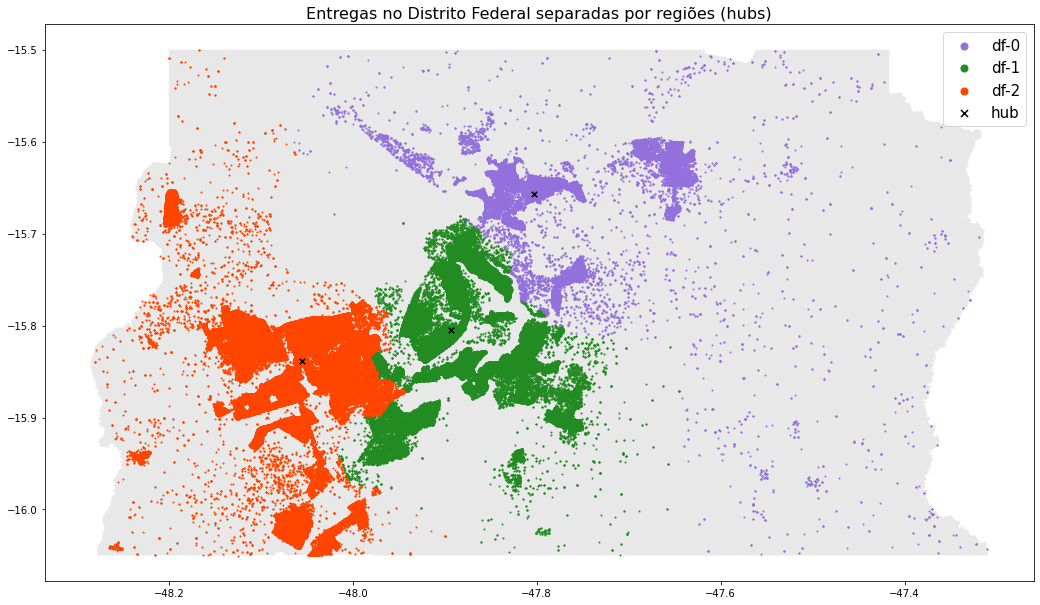

In [37]:
# criando o plot vazio
fig, ax = plt.subplots(figsize=(45/2.54, 45/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.5, color='lightgrey')

# plot mapa das regiões 
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color='mediumpurple', label='df-0')
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color='forestgreen', label='df-1')
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color='orangered', label='df-2')

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker='x', color='black', label='hub')

# plot da legenda
plt.title('Entregas no Distrito Federal separadas por regiões (hubs)', fontdict={'fontsize':16})
lgnd = plt.legend(prop={'size': 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

- **Insights**:

1. De acordo com a visualização as entregas estão corretamente alocadas aos seus respectivos hubs(centros de distribuição regional).

2. A região **df-2** e **df-0** que corresponde as regiões de Taguatinga, Ceilândia, Samambaia, Sobradinho, Planaltina e São Sebastião possui as entregas em locais mais distantes, o que pode gerar um tempo e preço de entrega maior.

3. A região central **df-1** que corresponde a Brasília, Guará, Cruzeiro e Lago Sul possui a maior concentração de entregas.


### **5.2. Gráfico de entregas por região** 

- **Agregação**:

In [38]:
grafico = pd.DataFrame(loggi_df[['region', 'vehicle_capacity']]. value_counts(normalize=True)).reset_index()
grafico.rename(columns={0:'region_percent'}, inplace=True)
grafico.head()

,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


- **Visualização**:

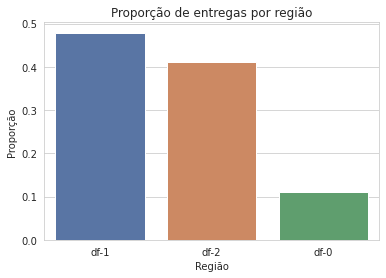

In [39]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=grafico, x='region', y='region_percent', ci=None, palette='deep')
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

* df-1 e df-2corresconde a 88% das entregas.
* df-0 corresponde a 11%.

Insights:

1. As regiões **df-1** e **df-2** possuem ,respectivamente, as maiores proporções na quantidade de entregas realizadas. Enquanto, a região df-0 possui a menor.

2. A capacidade dos veículos é mesma para todos os **hubs**, logo os **veículos** poderiam ser deslocados para as regiões de maior tráfego.